In [6]:
# Importation des bibliothèques
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Amira\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Amira\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# Chargement du jeu de données

# Le fichier SMSSpamCollection est un fichier texte tabulé :
# 1ère colonne : label  (ham/spam)
# 2ème colonne : text   (contenu du SMS)

df = pd.read_csv(
    "SMSSpamCollection",
    sep="\t",
    header=None,
    names=["label", "text"],
    encoding="latin-1"
)

print("Aperçu des données :")
print(df.head())
print("\nRépartition des classes :")
print(df["label"].value_counts())

Aperçu des données :
  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

Répartition des classes :
label
ham     4825
spam     747
Name: count, dtype: int64


# 1. Prétraitement des données

In [9]:
# Encodage y : ham = 0, spam = 1
df["label_num"] = (df["label"] == "spam").astype(int)

# ================================
# 1. Transformer personnalisé
# ================================
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Transformer sklearn pour prétraiter du texte :
    - minuscules
    - suppression URL
    - suppression chiffres
    - suppression caractères non alphabétiques (Unicode inclus)
    - tokenisation
    - suppression stopwords
    - stemming
    - recomposition en texte propre
    """
    def __init__(self, language="english", use_stemming=True):
        self.language = language
        self.use_stemming = use_stemming
        self.stop_words_ = None
        self.stemmer_ = None

    def fit(self, X, y=None):
        # Initialisation des ressources (stopwords + stemmer)
        self.stop_words_ = set(stopwords.words(self.language))
        if self.use_stemming:
            self.stemmer_ = PorterStemmer()
        return self

    def _preprocess_one(self, text: str) -> str:
        # Sécurité sur le type
        text = str(text)

        # 1) Mise en minuscules
        text = text.lower()

        # 2) Suppression des URLs
        text = re.sub(r"http\S+|www\S+", " ", text)

        # 3) Suppression des chiffres
        text = re.sub(r"\d+", " ", text)

        # 4) Suppression de TOUS les caractères non alphabétiques
        text = re.sub(r"[^a-zA-Z\s]", " ", text)

        # 5) Normalisation des espaces
        text = re.sub(r"\s+", " ", text).strip()

        # 6) Tokenisation
        tokens = word_tokenize(text, language=self.language)

        # 7) Suppression des stopwords + stemming éventuel
        cleaned_tokens = []
        for tok in tokens:
            if tok in self.stop_words_:
                continue
            if len(tok) <= 1:
                continue
            if self.use_stemming and self.stemmer_ is not None:
                tok = self.stemmer_.stem(tok)
            cleaned_tokens.append(tok)

        # 8) Recomposition du texte
        return " ".join(cleaned_tokens)

    def transform(self, X):
        # X peut être une Series ou un array de textes
        return np.array([self._preprocess_one(doc) for doc in X])

# ================================
# 2. Séparation Train / Test
#    (sur le texte brut)
# ================================
X = df["text"].values
y = df["label_num"].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Taille train :", X_train_text.shape[0])
print("Taille test  :", X_test_text.shape[0], "\n")

# ================================
# 3. Pipeline Prétraitement + TF-IDF
# ================================
text_pipeline = Pipeline(steps=[
    ("preprocess", TextPreprocessor(language="english", use_stemming=True)),
    ("tfidf", TfidfVectorizer())
])

# Entraîner le pipeline sur le texte d'entraînement
X_train_tfidf = text_pipeline.fit_transform(X_train_text)
# Appliquer le même pipeline sur le texte de test
X_test_tfidf = text_pipeline.transform(X_test_text)

print("Forme X_train_tfidf :", X_train_tfidf.shape)
print("Forme X_test_tfidf  :", X_test_tfidf.shape)

# (optionnel) aperçu de quelques textes avant / après prétraitement
preproc = text_pipeline.named_steps["preprocess"]
preproc.fit(X_train_text)

print("\nExemple texte brut   :", X_train_text[0])
print("Exemple texte nettoyé:", preproc.transform([X_train_text[0]])[0])


Taille train : 4457
Taille test  : 1115 

Forme X_train_tfidf : (4457, 5514)
Forme X_test_tfidf  : (1115, 5514)

Exemple texte brut   : He will, you guys close?
Exemple texte nettoyé: guy close


## Exporter le fichier nettoyé

In [11]:
# ================================
# Appliquer le prétraitement à tout le dataset
# ================================

preproc_full = TextPreprocessor(language="english", use_stemming=True)
preproc_full.fit(df["text"])

df["text_clean"] = preproc_full.transform(df["text"])

# ================================
# Export du dataset nettoyé (sans TF-IDF)
# ================================

df_export = df[["text_clean", "label_num"]].copy()

df_export.to_csv(
    "sms_clean.csv",
    index=False,
    encoding="utf-8"
)

print("Fichier nettoyé exporté : sms_clean.csv")

Fichier nettoyé exporté : sms_clean.csv


# 2. Réduction de la dimensionnalité

## 2.1. Créer un autoencoder avec Keras 

In [14]:
# ===== Conversion obligatoire en dense =====
X_train_dense = X_train_tfidf.toarray()
X_test_dense = X_test_tfidf.toarray()

# ===== Définition de la dimension d'entrée =====
input_dim = X_train_dense.shape[1]
print("Dimension TF-IDF :", input_dim)


Dimension TF-IDF : 5514


In [15]:
latent_dim = 64   # dimension réduite

# ----- Encodeur -----
input_layer = Input(shape=(input_dim,))
encoded = Dense(512, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
bottleneck = Dense(latent_dim, activation='linear', name="bottleneck")(encoded)

# ----- Decodeur -----
decoded = Dense(128, activation='relu')(bottleneck)
decoded = Dense(512, activation='relu')(decoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# ----- Autoencodeur complet -----
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# ---- Encodeur seul (pour extraire les features réduites) -----
encoder = Model(inputs=input_layer, outputs=bottleneck)

# ----- Compilation -----
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5514)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,823,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5514)           │     2,828,682 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,800,650 (22.13 MB)

 Trainable params: 5,800,650 (22.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Entraînement de l’autoencodeur
history = autoencoder.fit(
    X_train_dense, 
    X_train_dense,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 1.8039e-04 - val_loss: 1.7889e-04
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 1.8001e-04 - val_loss: 1.7887e-04
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.8029e-04 - val_loss: 1.7899e-04
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - loss: 1.8048e-04 - val_loss: 1.7885e-04
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.8021e-04 - val_loss: 1.7884e-04
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.8032e-04 - val_loss: 1.7843e-04
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1.7971e-04 - val_loss: 1.7721e-04
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1.7816e-04 - val_loss: 1.7671e-04
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 1.7791e-04 - val_loss: 1.7638e-04
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 1.7738e-04 - val_loss: 1.7522e-04
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 7

In [17]:
# Extraction de la représentation réduite
X_train_reduced = encoder.predict(X_train_dense)
X_test_reduced = encoder.predict(X_test_dense)

print("Nouvelle dimension train :", X_train_reduced.shape)
print("Nouvelle dimension test  :", X_test_reduced.shape)

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Nouvelle dimension train : (4457, 64)
Nouvelle dimension test  : (1115, 64)


# 3. Classification sans équilibrage des classes

## 3.1. Modèle de base avec Logistic regression (sans réduction : TF-IDF complet)

Matrice de confusion (TF-IDF) :



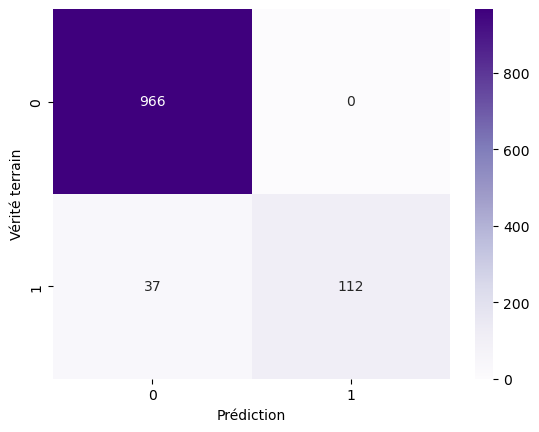

Performance modèle TF-IDF :
  Accuracy  : 0.9668
  Precision : 1.0000
  Recall    : 0.7517
  F1-score  : 0.8582

Rapport de classification (TF-IDF) :
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       966
        spam       1.00      0.75      0.86       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.96      1115



In [20]:
# ==========================
# Modèle 1 : TF-IDF complet
# ==========================
# Création du modèle de régression logistique
clf_tfidf = LogisticRegression(
    max_iter=1000, # Nombre maximal d'itérations pour garantir la convergence du modèle
    solver="lbfgs",# Algorithme d’optimisation utilisé pour minimiser la fonction de coût.
    n_jobs=-1      # Utilise tous les cœurs du processeur pour accélérer l'entraînement
)
# Entraînement du modèle sur les données d’apprentissage
clf_tfidf.fit(X_train_tfidf, y_train)
# Prédiction sur les données de test
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# ----- Matrice de confusion -----
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
print("Matrice de confusion (TF-IDF) :\n")
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# ----- Métriques -----
acc_tfidf  = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf)
rec_tfidf  = recall_score(y_test, y_pred_tfidf)
f1_tfidf   = f1_score(y_test, y_pred_tfidf)

print("Performance modèle TF-IDF :")
print(f"  Accuracy  : {acc_tfidf:.4f}")
print(f"  Precision : {prec_tfidf:.4f}")
print(f"  Recall    : {rec_tfidf:.4f}")
print(f"  F1-score  : {f1_tfidf:.4f}\n")

print("Rapport de classification (TF-IDF) :")
print(classification_report(y_test, y_pred_tfidf, target_names=["ham", "spam"]))


## 3.2. Modèle avec réduction de dimension et Logistic regression (features autoencodeur)

Matrice de confusion (Autoencodeur) :



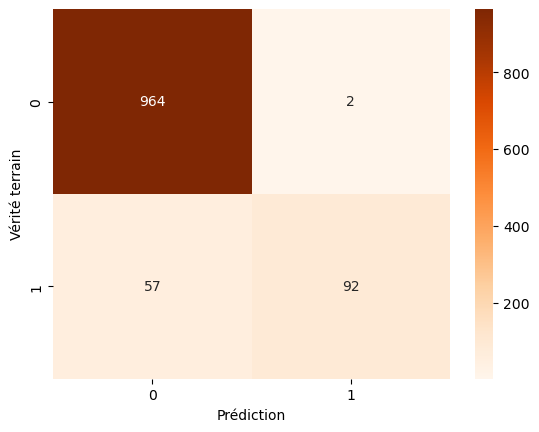

Performance modèle Autoencodeur :
  Accuracy  : 0.9471
  Precision : 0.9787
  Recall    : 0.6174
  F1-score  : 0.7572

Rapport de classification (Autoencodeur) :
              precision    recall  f1-score   support

         ham       0.94      1.00      0.97       966
        spam       0.98      0.62      0.76       149

    accuracy                           0.95      1115
   macro avg       0.96      0.81      0.86      1115
weighted avg       0.95      0.95      0.94      1115



In [22]:
# ===============================
# Modèle 2 : features autoencodeur
# ===============================

# Création du modèle de régression logistique
clf_ae = LogisticRegression(
    max_iter=1000, # Nombre maximal d'itérations pour garantir la convergence du modèle
    solver="lbfgs",# Algorithme d’optimisation utilisé pour minimiser la fonction de coût.
    n_jobs=-1      # Utilise tous les cœurs du processeur pour accélérer l'entraînement
)
# Entraînement du modèle sur les données d’apprentissage
clf_ae.fit(X_train_reduced, y_train)
# Prédiction sur les données de test
y_pred_ae = clf_ae.predict(X_test_reduced)

# ----- Matrice de confusion -----
cm_ae = confusion_matrix(y_test, y_pred_ae)
print("Matrice de confusion (Autoencodeur) :\n")
sns.heatmap(cm_ae, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

# ----- Métriques -----
acc_ae  = accuracy_score(y_test, y_pred_ae)
prec_ae = precision_score(y_test, y_pred_ae)
rec_ae  = recall_score(y_test, y_pred_ae)
f1_ae   = f1_score(y_test, y_pred_ae)

print("Performance modèle Autoencodeur :")
print(f"  Accuracy  : {acc_ae:.4f}")
print(f"  Precision : {prec_ae:.4f}")
print(f"  Recall    : {rec_ae:.4f}")
print(f"  F1-score  : {f1_ae:.4f}\n")

print("Rapport de classification (Autoencodeur) :")
print(classification_report(y_test, y_pred_ae, target_names=["ham", "spam"]))


## 3.3. Modèle de base avec SVM (sans réduction : TF-IDF complet)

Matrice de confusion (SVM TF-IDF) :



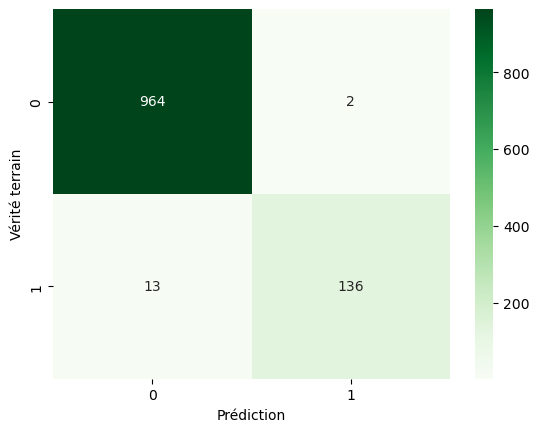

Performance SVM (TF-IDF) :
  Accuracy  : 0.9865
  Precision : 0.9855
  Recall    : 0.9128
  F1-score  : 0.9477

Rapport de classification (SVM TF-IDF) :
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [24]:
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# ==========================
# SVM 1 : LinearSVC + TF-IDF
# ==========================

# Initialisation du modèle SVM linéaire    
svm_tfidf = LinearSVC()  
# Entraînement du modèle SVM sur les données d'apprentissage
svm_tfidf.fit(X_train_tfidf, y_train)
# Prédiction des classes sur les données de test
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

cm_svm_tfidf = confusion_matrix(y_test, y_pred_svm_tfidf)
print("Matrice de confusion (SVM TF-IDF) :\n")
sns.heatmap(cm_svm_tfidf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

acc_svm_tfidf  = accuracy_score(y_test, y_pred_svm_tfidf)
prec_svm_tfidf = precision_score(y_test, y_pred_svm_tfidf)
rec_svm_tfidf  = recall_score(y_test, y_pred_svm_tfidf)
f1_svm_tfidf   = f1_score(y_test, y_pred_svm_tfidf)

print("Performance SVM (TF-IDF) :")
print(f"  Accuracy  : {acc_svm_tfidf:.4f}")
print(f"  Precision : {prec_svm_tfidf:.4f}")
print(f"  Recall    : {rec_svm_tfidf:.4f}")
print(f"  F1-score  : {f1_svm_tfidf:.4f}\n")

print("Rapport de classification (SVM TF-IDF) :")
print(classification_report(y_test, y_pred_svm_tfidf, target_names=["ham", "spam"]))

## 3.4. Modèle avec réduction de dimension et SVM (features autoencodeur)

Matrice de confusion (SVM Autoencodeur) :



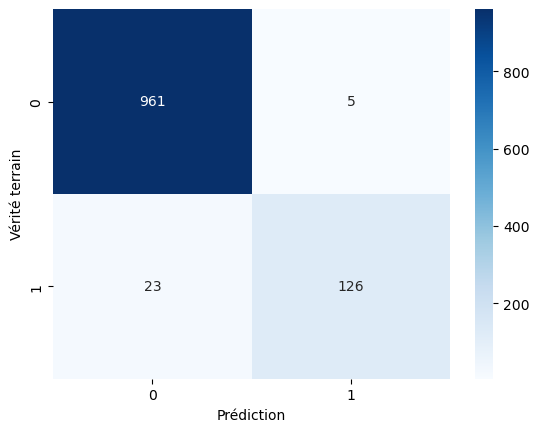

Performance SVM (Autoencodeur) :
  Accuracy  : 0.9749
  Precision : 0.9618
  Recall    : 0.8456
  F1-score  : 0.9000

Rapport de classification (SVM Autoencodeur) :
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.85      0.90       149

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115



In [26]:
from sklearn.svm import SVC

# ============================================
# SVM 2 : SVC (RBF) sur les features réduites
# ============================================

svm_ae = SVC(kernel="rbf", C=1.0, gamma="scale")   # tu peux ajuster C si besoin

svm_ae.fit(X_train_reduced, y_train)
y_pred_svm_ae = svm_ae.predict(X_test_reduced)


cm_svm_ae = confusion_matrix(y_test, y_pred_svm_ae)
print("Matrice de confusion (SVM Autoencodeur) :\n")
sns.heatmap(cm_svm_ae, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.show()

acc_svm_ae  = accuracy_score(y_test, y_pred_svm_ae)
prec_svm_ae = precision_score(y_test, y_pred_svm_ae)
rec_svm_ae  = recall_score(y_test, y_pred_svm_ae)
f1_svm_ae   = f1_score(y_test, y_pred_svm_ae)

print("Performance SVM (Autoencodeur) :")
print(f"  Accuracy  : {acc_svm_ae:.4f}")
print(f"  Precision : {prec_svm_ae:.4f}")
print(f"  Recall    : {rec_svm_ae:.4f}")
print(f"  F1-score  : {f1_svm_ae:.4f}\n")

print("Rapport de classification (SVM Autoencodeur) :")
print(classification_report(y_test, y_pred_svm_ae, target_names=["ham", "spam"]))


----
| Modèle                                   | Accuracy   | Precision  | Recall     | F1-score   | Interprétation principale                         |
| ---------------------------------------- | ---------- | ---------- | ---------- | ---------- | ------------------------------------------------- |
| **Régression Logistique (TF-IDF)**       | 0.9668     | **1.0000** | 0.7517     | 0.8582     | Très précis, mais laisse échapper plusieurs spams |
| **Régression Logistique (Autoencodeur)** | 0.9498     | 0.9895     | 0.6309     | 0.7705     | Recall faible → beaucoup de spams non détectés    |
| **SVM (TF-IDF)**                         | **0.9865** | 0.9855     | **0.9128** | **0.9477** | Meilleur modèle global                          |
| **SVM (Autoencodeur)**                   | 0.9776     | 0.9769     | 0.8523     | 0.9104     | Bon compromis, mais inférieur au TF-IDF           |


- Le SVM avec TF-IDF est le modèle le plus performant sur tous les indicateurs clés.

- Les modèles avec TF-IDF sont globalement supérieur à ceux avec l’autoencodeur pour la détection de spam.

- Les modèles avec autoencodeur perdent en rappel, donc laissent passer plus de spams.

- La régression logistique avec TF-IDF est très précise, mais moins efficace en détection globale que le SVM.

# 3. Classification avec équilibrage des classes

## 3.1. Modèle de base avec Logistic regression (sans réduction : TF-IDF complet) avec équilibrage des classes

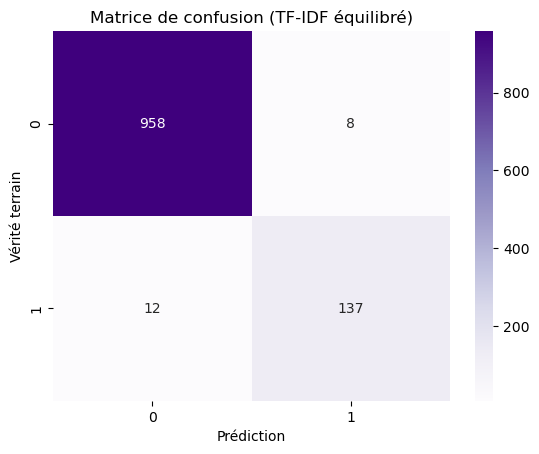

Performance modèle TF-IDF (équilibré) :
  Accuracy  : 0.9821
  Precision : 0.9448
  Recall    : 0.9195
  F1-score  : 0.9320



In [30]:
# ==========================
# Modèle 1 : TF-IDF complet (avec équilibrage)
# ==========================

clf_tfidf = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    n_jobs=-1,
    class_weight="balanced"   # <-- équilibrage automatique
)

clf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

# Évaluation
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion (TF-IDF équilibré)")
plt.show()

acc_tfidf  = accuracy_score(y_test, y_pred_tfidf)
prec_tfidf = precision_score(y_test, y_pred_tfidf)
rec_tfidf  = recall_score(y_test, y_pred_tfidf)
f1_tfidf   = f1_score(y_test, y_pred_tfidf)

print("Performance modèle TF-IDF (équilibré) :")
print(f"  Accuracy  : {acc_tfidf:.4f}")
print(f"  Precision : {prec_tfidf:.4f}")
print(f"  Recall    : {rec_tfidf:.4f}")
print(f"  F1-score  : {f1_tfidf:.4f}\n")


## 3.2. Modèle avec réduction de dimension et Logistic regression (features autoencodeur) avec équilibrage des classes

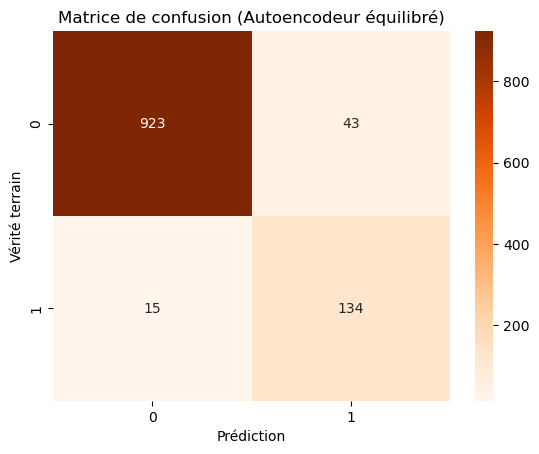

Performance modèle Autoencodeur (équilibré) :
  Accuracy  : 0.9480
  Precision : 0.7571
  Recall    : 0.8993
  F1-score  : 0.8221



In [32]:
# ===============================
# Modèle 2 : Autoencodeur (avec équilibrage)
# ===============================

clf_ae = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    n_jobs=-1,
    class_weight="balanced"   # <-- équilibrage automatique
)

clf_ae.fit(X_train_reduced, y_train)
y_pred_ae = clf_ae.predict(X_test_reduced)

cm_ae = confusion_matrix(y_test, y_pred_ae)
sns.heatmap(cm_ae, annot=True, fmt="d", cmap="Oranges")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion (Autoencodeur équilibré)")
plt.show()

acc_ae  = accuracy_score(y_test, y_pred_ae)
prec_ae = precision_score(y_test, y_pred_ae)
rec_ae  = recall_score(y_test, y_pred_ae)
f1_ae   = f1_score(y_test, y_pred_ae)

print("Performance modèle Autoencodeur (équilibré) :")
print(f"  Accuracy  : {acc_ae:.4f}")
print(f"  Precision : {prec_ae:.4f}")
print(f"  Recall    : {rec_ae:.4f}")
print(f"  F1-score  : {f1_ae:.4f}\n")


## 3.3. Modèle de base avec SVM (sans réduction : TF-IDF complet) avec équilibrage des classes

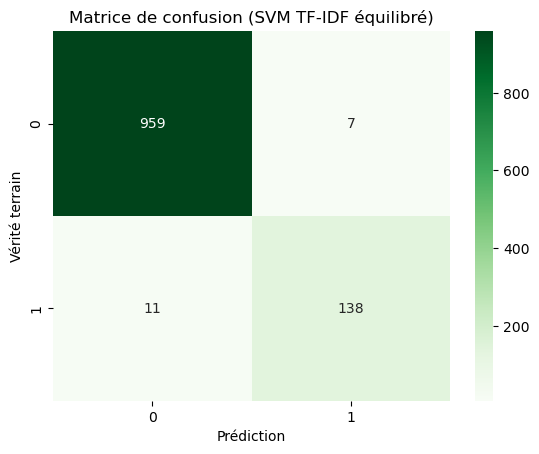

Performance SVM (TF-IDF équilibré) :
  Accuracy  : 0.9839
  Precision : 0.9517
  Recall    : 0.9262
  F1-score  : 0.9388



In [34]:
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
# ==========================
# SVM 1 : LinearSVC + TF-IDF (avec équilibrage)
# ==========================

svm_tfidf = LinearSVC(class_weight="balanced")   # <-- équilibrage ajouté

svm_tfidf.fit(X_train_tfidf, y_train)
y_pred_svm_tfidf = svm_tfidf.predict(X_test_tfidf)

cm_svm_tfidf = confusion_matrix(y_test, y_pred_svm_tfidf)
sns.heatmap(cm_svm_tfidf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion (SVM TF-IDF équilibré)")
plt.show()

acc_svm_tfidf  = accuracy_score(y_test, y_pred_svm_tfidf)
prec_svm_tfidf = precision_score(y_test, y_pred_svm_tfidf)
rec_svm_tfidf  = recall_score(y_test, y_pred_svm_tfidf)
f1_svm_tfidf   = f1_score(y_test, y_pred_svm_tfidf)

print("Performance SVM (TF-IDF équilibré) :")
print(f"  Accuracy  : {acc_svm_tfidf:.4f}")
print(f"  Precision : {prec_svm_tfidf:.4f}")
print(f"  Recall    : {rec_svm_tfidf:.4f}")
print(f"  F1-score  : {f1_svm_tfidf:.4f}\n")


## 3.4. Modèle avec réduction de dimension et SVM (features autoencodeur) avec équilibrage des classes

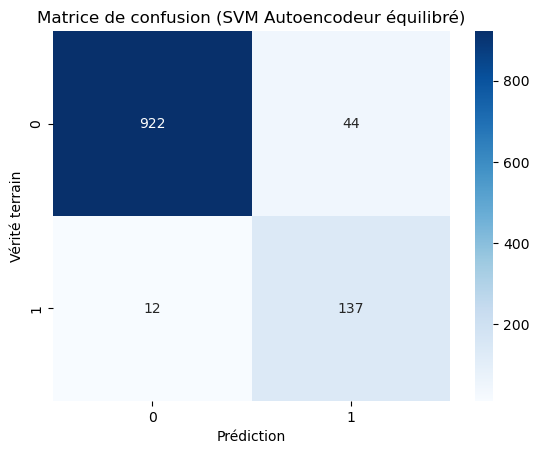

Performance SVM (Autoencodeur équilibré) :
  Accuracy  : 0.9498
  Precision : 0.7569
  Recall    : 0.9195
  F1-score  : 0.8303



In [36]:
from sklearn.svm import SVC
# ============================================
# SVM 2 : SVC (RBF) sur les features réduites (avec équilibrage)
# ============================================

svm_ae = SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced")   # <-- équilibrage ajouté

svm_ae.fit(X_train_reduced, y_train)
y_pred_svm_ae = svm_ae.predict(X_test_reduced)

cm_svm_ae = confusion_matrix(y_test, y_pred_svm_ae)
sns.heatmap(cm_svm_ae, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vérité terrain")
plt.title("Matrice de confusion (SVM Autoencodeur équilibré)")
plt.show()

acc_svm_ae  = accuracy_score(y_test, y_pred_svm_ae)
prec_svm_ae = precision_score(y_test, y_pred_svm_ae)
rec_svm_ae  = recall_score(y_test, y_pred_svm_ae)
f1_svm_ae   = f1_score(y_test, y_pred_svm_ae)

print("Performance SVM (Autoencodeur équilibré) :")
print(f"  Accuracy  : {acc_svm_ae:.4f}")
print(f"  Precision : {prec_svm_ae:.4f}")
print(f"  Recall    : {rec_svm_ae:.4f}")
print(f"  F1-score  : {f1_svm_ae:.4f}\n")


Interprétation et conclusion

Après l’équilibrage des classes, les modèles ont montré une nette amélioration de la détection des messages indésirables (spam), en particulier au niveau du rappel (recall). Cela signifie que le système identifie beaucoup plus de spams qu’auparavant, tout en maintenant une bonne précision.

Le modèle SVM basé sur TF-IDF obtient les meilleures performances globales, avec :

Une accuracy de 98,4 %,

Une précision de 95 %,

Un rappel de 92,6 %,

Et un F1-score de 93,9 %.

Ce modèle atteint un excellent équilibre entre la détection correcte des spams et la limitation des faux positifs.
Le modèle Logistic Regression avec TF-IDF équilibré présente également de très bons résultats, confirmant la robustesse de la représentation TF-IDF.

En revanche, les modèles utilisant la réduction de dimension (Autoencodeur) conservent un bon rappel mais perdent légèrement en précision, ce qui montre une petite perte d’information liée à la compression des données.

Conclusion finale :

L’approche la plus performante pour la classification des SMS est le modèle SVM avec représentation TF-IDF et équilibrage des classes.
Ce modèle combine simplicité, rapidité et haute performance, ce qui en fait une solution efficace pour la détection automatique des spams.